# データの読み込み

In [3]:
import pickle as pkl

In [6]:
with open("../dataset/ml-100k/item_profile.arr", 'rb') as f:
    item_prof_vecs = pkl.load(f)
item_prof_vecs

array([[0, 0, 1, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [7]:
item_prof_vecs.shape

(1682, 26)

In [9]:
with open("../dataset/ml-100k/user_profile.arr", 'rb') as f:
    user_prof_vecs = pkl.load(f)
user_prof_vecs

array([[0.25757576, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.6969697 , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.24242424, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.1969697 , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.62121212, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.22727273, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])

In [10]:
user_prof_vecs.shape

(943, 135)

In [107]:
len(user_prof_vecs[0][0:24])

24

In [12]:
import pandas as pd

In [13]:
dir_name = "valcase_1"

df_m = pd.read_csv("../dataset/ml-100k/{}/matrix.csv".format(dir_name), header=None)
train_dataset = pd.read_csv("../dataset/ml-100k/{}/train_data.csv".format(dir_name), names=['user_id','movie_id','rating'])
test_dataset  = pd.read_csv("../dataset/ml-100k/{}/test_data.csv".format(dir_name),  names=['user_id','movie_id','rating'])

出力ベクトルの作成

In [52]:
y_train = train_dataset['rating'].values

In [94]:
y_train, y_train.shape

(array([5, 3, 4, ..., 3, 3, 3]), (80000,))

In [95]:
y_test = test_dataset['rating'].values

In [96]:
y_test, y_test.shape

(array([5, 3, 5, ..., 3, 3, 5]), (20000,))

In [287]:
set(y_train)

{1, 2, 3, 4, 5}

In [288]:
set(y_test)

{1, 2, 3, 4, 5}

入力ベクトルの作成

In [68]:
x_train_index = train_dataset[['user_id', 'movie_id']].values

In [69]:
x_train_index.shape

(80000, 2)

In [89]:
x_test_index = test_dataset[['user_id', 'movie_id']].values

In [90]:
x_test_index.shape

(20000, 2)

In [180]:
x_train =  np.empty((0,50), int)
for i in range(x_train_index.shape[0]):
    x_train=np.append(x_train, np.array([np.hstack((user_prof_vecs[x_train_index[i][0]][0:24], item_prof_vecs[x_train_index[i][1]]))]), axis=0)

In [181]:
x_train.shape

(80000, 50)

In [184]:
x_test = np.empty((0, 50), int)
for i in range(x_test_index.shape[0]):
    x_test= np.append(x_test, np.array([np.hstack((user_prof_vecs[x_test_index[i][0]][0:24], item_prof_vecs[x_test_index[i][1]]))]), axis=0)

In [185]:
x_test.shape

(20000, 50)

# deeplearningのモデル

### 入力
- ユーザープロファイル + アイテムプロファイルのベクトル

- ユーザープロファイル [年齢(最大・最小正規化済):1次元, 性別(male,female):2次元, 職種:21次元, zip code:111次元]
- アイテムプロファイル [ジャンル(複数該当有):18次元, 上映年代(20~90年代):8次元]

### 出力
- 評価値(movie_rating)


In [205]:
import time

In [222]:
import numpy as np
import tensorflow as tf

In [37]:
def init_weight(shape, st_dev):
    weight = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return(weight)

def init_bias(shape, st_dev):
    bias = tf.Variable(tf .random_normal (shape, stddev=st_dev))
    return(bias)

In [38]:
def fully_connected(input_layer, weights, biases):
    layer = tf.add(tf.matmul (input_layer, weights), biases) 
    return(tf.nn.relu(layer))

In [403]:
def tensor_model(x_train, x_test, y_train, y_test, batch_size_, iter_, node1, node2, node3):
    sess = tf.Session()
    batch_size=batch_size_
    x_dim=x_train.shape[1]

    x_data = tf.placeholder(shape = [None, x_dim], dtype = tf.float32)
    y_target = tf.placeholder(shape = [None, 1], dtype = tf.float32)

    #1つ目の層(25個のノードを持つ隠れ層)を作成
    weight_1 = init_weight(shape=[x_dim, node1], st_dev=10.0)
    bias_1= init_bias(shape=[node1], st_dev=10.0)
    layer_1 = fully_connected(x_data, weight_1, bias_1)

    # 2つ目の層(10個のノードを持つ隠れ層)を作成
    weight_2 = init_weight(shape=[node1, node2], st_dev=10.0)
    bias_2 = init_bias(shape=[node2], st_dev=10.0)
    layer_2 = fully_connected(layer_1, weight_2, bias_2)

    #3つ目の層(3個のノードを持つ隠れ層)を作成
    weight_3 = init_weight(shape=[node2, node3], st_dev=10.0)
    bias_3 = init_bias(shape=[node3], st_dev=10.0)
    layer_3 = fully_connected(layer_2, weight_3, bias_3)

    # #出力層(1個の出力)を作成
    weight_4 = init_weight(shape=[node3, 1], st_dev=10.0)
    bias_4 = init_bias(shape=[1], st_dev=10.0)
    final_output = fully_connected(layer_3, weight_4, bias_4)
    
    #損失関数を作成
    mse_loss = tf. reduce_mean(tf.abs(y_target - final_output))
    mae_loss = tf.reduce_mean(tf.map_fn(tf.abs, y_target - final_output))
#     mse_loss = tf.keras.metrics.mean_absolute_error(
#     y_target,
#     final_output
# )
    #最適化関数を作成
    my_opt = tf.train.AdamOptimizer(0.05)
#     train_step = my_opt.minimize(mse_loss)
    train_step = my_opt.minimize(mae_loss)
    #変数を初期化
    init = tf.global_variables_initializer()
    sess. run(init)
    
#     prediction = tf.round(tf.nn. sigmoid(final_output))
#     predictions_correct = tf. cast(tf. equal (prediction, y_target), tf.float32)
#     accuracy = tf.reduce_mean(predictions_correct)
    #損失ベクトルを初期化
    loss_vec = []
    test_loss =[]
    train_acc = []
    test_acc = []
    start_time= time.time()
    for i in range(iter_):
        #バッチを選択するためのインデックスをランダムに選択
        rand_index = np.random.choice(len(x_train), size=batch_size) #ランダムな値でバッチを取得
        rand_x = x_train[rand_index]
        rand_y = np.transpose([y_train[rand_index]]) #トレーニングステップを実行
        sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

        #トレーニングセットの損失値を保存
        temp_loss = sess.run(mse_loss, feed_dict = {
            x_data: rand_x,
            y_target: rand_y})
        loss_vec.append(temp_loss)

        #テストセットの損失値を保存 
        test_temp_loss = sess.run(mse_loss, feed_dict={
            x_data: x_test,
            y_target: np.transpose([y_test])})
        test_loss.append(test_temp_loss)
        
        if i %100==0:
            print('iter=', i, 'time=', time.time()-start_time)            
            #トレーニングセットの正解率を取得
#             temp_acc_train = sess.run(accuracy, feed_dict={
#                 x_data: x_train, y_target: np.transpose([y_train])})
#             train_acc.append(temp_acc_train)
#             #テストセットの正解率を取得
#             temp_acc_test = sess.run(accuracy, feed_dict={
#                 x_data: x_test, y_target: np.transpose([y_test])}) 
#             test_acc. append(temp_acc_test)
            
    return loss_vec, test_loss

結果のプロット

In [200]:
import matplotlib.pyplot as plt

In [250]:
def result_plot(loss_vec, test_loss):
    plt.plot(loss_vec, 'k-', label='Train Loss') 
    plt.plot(test_loss, 'r', label='Test Loss') 
    plt.title('Loss (MSE) per Generation') 
    plt.xlabel('Generation')
    plt.ylabel('Loss') 
    plt.legend(loc='upper right') 
    plt.show()

# 実験

## No.1
#### 入力
- ユーザープロファイル(24次元)+アイテムプロファイル(26次元) = 50次元
- ユーザープロファイル <年齢(最大・最小正規化済):1次元, 性別(male,female):2次元, 職種:21次元>
- アイテムプロファイル <ジャンル(複数該当有):18次元, 上映年代(20~90年代):8次元>

#### 出力
- 評価値(movie_rating)

#### パラメータ
- batch_size = 128
- iteration = 512
- node1(1つめの層の数)= 25
- node2(2つめの層の数)=10
- node3(3つめの層の数)=3

#### 評価
- MSE(平均二乗誤差)
- MAE(平均絶対誤差)


iter= 0 time= 0.6507346630096436
iter= 100 time= 3.510493278503418
iter= 200 time= 6.251497030258179
iter= 300 time= 8.911837816238403
iter= 400 time= 11.995752334594727
iter= 500 time= 14.794274091720581


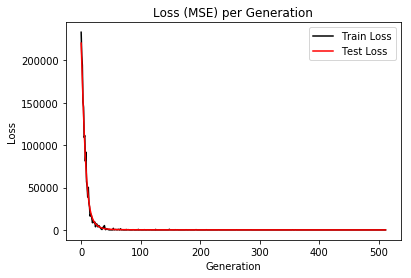

In [404]:
loss_vec, test_loss = tensor_model(x_train, x_test, y_train, y_test, batch_size_=128, iter_=512, node1=25, node2=10, node3=3)
result_plot(loss_vec, test_loss)

In [405]:
loss_vec

[233011.5,
 205513.33,
 194168.25,
 150812.47,
 144779.55,
 108960.06,
 111285.055,
 81082.49,
 91716.055,
 57017.76,
 51677.65,
 38681.35,
 50225.3,
 31989.988,
 27037.258,
 16263.463,
 18800.457,
 17840.516,
 12993.492,
 8431.187,
 10988.398,
 9790.73,
 8339.7295,
 9224.359,
 3695.6216,
 5889.3853,
 7155.921,
 5449.875,
 3625.8374,
 5054.405,
 5014.957,
 3063.4553,
 3049.3704,
 1816.1345,
 865.796,
 476.28342,
 2779.6782,
 3135.3352,
 3148.5896,
 5151.574,
 2038.5973,
 259.27496,
 815.4769,
 1537.0593,
 743.83484,
 667.1531,
 204.84338,
 702.84503,
 3.4609375,
 57.594124,
 115.07946,
 3.53125,
 130.26239,
 3.53125,
 1889.5657,
 303.50244,
 114.26585,
 322.01733,
 524.57025,
 408.6817,
 3.3828125,
 220.19926,
 708.62427,
 561.2114,
 46.28672,
 3.640625,
 1396.4849,
 520.1536,
 3.4921875,
 152.96265,
 242.0075,
 3.4921875,
 3.640625,
 3.625,
 384.26544,
 3.5546875,
 507.97247,
 68.51112,
 205.98203,
 362.80383,
 53.418835,
 3.515625,
 3.7109375,
 3.5703125,
 3.53125,
 3.6953125,
 3.507

In [406]:
test_loss

[220204.28,
 196865.84,
 174609.56,
 153797.64,
 134450.98,
 116665.1,
 100468.586,
 86034.4,
 73232.195,
 62314.453,
 53017.816,
 45088.113,
 38350.688,
 32716.396,
 27913.7,
 23919.479,
 20544.756,
 17708.13,
 15428.44,
 13555.369,
 11918.984,
 10474.39,
 9228.167,
 8181.634,
 7292.094,
 6490.946,
 5801.4062,
 5186.01,
 4626.609,
 4127.082,
 3665.2793,
 3253.2002,
 2906.265,
 2610.9822,
 2362.1587,
 2154.7756,
 1969.2664,
 1805.1096,
 1655.2976,
 1513.0577,
 1384.0616,
 1271.366,
 1172.8052,
 1085.1108,
 1008.3253,
 937.0772,
 874.3208,
 815.5642,
 764.454,
 718.9569,
 678.5036,
 642.9769,
 611.7127,
 584.792,
 557.1004,
 531.2673,
 507.8182,
 486.16635,
 463.952,
 442.2314,
 424.1818,
 407.85345,
 392.22064,
 376.14368,
 361.31955,
 348.22067,
 333.7896,
 320.50204,
 308.6803,
 297.7186,
 285.28595,
 274.3796,
 264.57224,
 255.67944,
 245.85645,
 237.57535,
 228.74425,
 220.59547,
 212.5933,
 205.46513,
 198.72556,
 192.71837,
 187.37448,
 182.53223,
 178.20174,
 174.30255,
 170.807

## No.2
#### 入力
- ユーザープロファイル(24次元)のみ = 24次元
- ユーザープロファイル <年齢(最大・最小正規化済):1次元, 性別(male,female):2次元, 職種:21次元>
            
#### 出力
- 評価値(movie_rating)

#### パラメータ
- batch_size = 124
- iteration = 625
- node1(1つめの層の数)= 70
- node2(2つめの層の数)=35
- node3(3つめの層の数)=10

#### 評価
- MSE(平均二乗誤差)

In [397]:
user_x_train = x_train[:, 0:24]
user_x_test = x_test[:, 0:24]

In [375]:
user_x_train.shape

(80000, 24)

In [378]:
user_x_test.shape

(20000, 24)

iter= 0 time= 0.42524003982543945
iter= 100 time= 1.1807763576507568
iter= 200 time= 2.014390230178833
iter= 300 time= 2.7838404178619385
iter= 400 time= 3.5702695846557617
iter= 500 time= 4.437382221221924


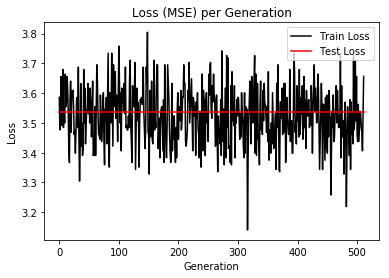

In [398]:
loss_vec, test_loss = tensor_model(user_x_train, user_x_test, y_train, y_test, batch_size_=128, iter_=512, node1=30, node2=20, node3=10)
result_plot(loss_vec, test_loss)

In [391]:
loss_vec

[162841.92,
 132934.67,
 126360.57,
 99766.42,
 112805.18,
 89759.25,
 77294.23,
 64149.754,
 51765.36,
 51979.22,
 35980.38,
 35741.25,
 27734.914,
 19074.898,
 12212.031,
 8415.898,
 7120.4263,
 5391.5664,
 6704.043,
 3194.3237,
 5447.1904,
 6209.9683,
 3408.9768,
 2003.5569,
 2848.7798,
 2209.9507,
 1924.2225,
 653.234,
 691.8571,
 346.4803,
 464.45172,
 543.3143,
 242.20581,
 922.399,
 74.156364,
 55.246403,
 362.73758,
 407.1947,
 103.70216,
 33.625015,
 151.48053,
 185.81319,
 28.676325,
 3.4612508,
 3.4921875,
 3.5703125,
 8.129732,
 3.3671875,
 3.375,
 3.53125,
 3.4765625,
 3.640625,
 3.390625,
 3.484375,
 3.3515625,
 3.4921875,
 3.609375,
 3.515625,
 3.484375,
 3.5,
 26.951864,
 3.453125,
 3.4296875,
 3.4296875,
 3.5546875,
 3.515625,
 3.4765625,
 3.4296875,
 3.484375,
 3.671875,
 3.5390625,
 3.40625,
 3.75,
 3.4453125,
 3.625,
 3.5,
 3.625,
 3.4921875,
 3.59375,
 3.53125,
 3.5546875,
 18.688965,
 3.6171875,
 3.546875,
 3.53125,
 3.6640625,
 26.600582,
 3.453125,
 3.5546875,
 

In [331]:
len(loss_vec_)

625

In [326]:
len(loss_vec[0])

128

In [ ]:
result_plot(loss_vec, test_loss)